# Part I - Exploring Ford GoBike System Data
## by Heiler Santiago Gómez Prieto

## Introduction

> The Ford GoBike System Data dataset contains information on bicycle trips made as part of the Ford GoBike program. This dataset includes travel information in terms of
* Location (Start and end points)
* Service duration
* Client identification (Sex, Birth year, Bike share for all trip)

## Preliminary Wrangling


In [1]:
!pip install folium

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from colour import Color
import folium

%matplotlib inline

### What is the structure of your dataset?

In [3]:
df = pd.read_csv("201902-fordgobike-tripdata.csv")
print("This dataset have " + str(df.shape[0]) + " rows y " + str(df.shape[1]) + " columns")

This dataset have 183412 rows y 16 columns


This data set is made up of 16 columns that include information on the duration of the routes, duration of the stations, and some characteristics of the users who make use of this service.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [5]:
df.head()

duration_sec                start_time                  end_time  \
0         52185  2019-02-28 17:32:10.1450  2019-03-01 08:01:55.9750   
1         42521  2019-02-28 18:53:21.7890  2019-03-01 06:42:03.0560   
2         61854  2019-02-28 12:13:13.2180  2019-03-01 05:24:08.1460   
3         36490  2019-02-28 17:54:26.0100  2019-03-01 04:02:36.8420   
4          1585  2019-02-28 23:54:18.5490  2019-03-01 00:20:44.0740   

   start_station_id                                start_station_name  \
0              21.0  Montgomery St BART Station (Market St at 2nd St)   
1              23.0                     The Embarcadero at Steuart St   
2              86.0                           Market St at Dolores St   
3             375.0                           Grove St at Masonic Ave   
4               7.0                               Frank H Ogawa Plaza   

   start_station_latitude  start_station_longitude  end_station_id  \
0               37.789625              -122.400811            13.0   
1               37.791464              -122.391034            81.0   
2               37.769305              -122.426826             3.0   
3               37.774836              -122.446546            70.0   
4               37.804562              -122.271738           222.0   

                               end_station_name  end_station_latitude  \
0                Commercial St at Montgomery St             37.794231   
1                            Berry St at 4th St             37.775880   
2  Powell St BART Station (Market St at 4th St)             37.786375   
3                        Central Ave at Fell St             37.773311   
4                         10th Ave at E 15th St             37.792714   

   end_station_longitude  bike_id   user_type  member_birth_year  \
0            -122.402923     4902    Customer             1984.0   
1            -122.393170     2535    Customer                NaN   
2            -122.404904     5905    Customer             1972.0   
3            -122.444293     6638  Subscriber             1989.0   
4            -122.248780     4898  Subscriber             1974.0   

  member_gender bike_share_for_all_trip  
0          Male                      No  
1           NaN                      No  
2          Male                      No  
3         Other                      No  
4          Male                     Yes

Starting with the data cleaning stage, the data is initially checked for duplicate records. It is found that it has none.

In [6]:
df[df.duplicated()]

Empty DataFrame
Columns: [duration_sec, start_time, end_time, start_station_id, start_station_name, start_station_latitude, start_station_longitude, end_station_id, end_station_name, end_station_latitude, end_station_longitude, bike_id, user_type, member_birth_year, member_gender, bike_share_for_all_trip]
Index: []

When validating null values, we have null values in *start_station_id, start_station_name, end_station_id, end_station_name, member_birth_year,* and *member_gender*. Each of these variables will be given a different treatment.

In [7]:
df.isna().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64

### Null values in *station_name*

In the columns associated with the stations, there is information on the longitude and latitude of the stations but not on their station_id or their name, and when validating the different longitudes and latitudes that appear, it is not possible to refer to other cases where the name of the stations is specified.

For this reason, it is proposed to create new names for unknown locations, so that the information in these records is not lost.

In [8]:
#Create new columns for existing latitude and longitude combinations

df["geo_location_start"] = df["start_station_latitude"].astype(str) + ", " + df["start_station_longitude"].astype(str)
df["geo_location_end"] = df["end_station_latitude"].astype(str) + ", " + df["end_station_longitude"].astype(str)

In [9]:
#https://stackoverflow.com/questions/1319338/combining-two-lists-and-removing-duplicates-without-removing-duplicates-in-orig

#Create a list with all the possible combinations of latitude and longitude that exist only for the records that do not count
#with a start_station_id

#List of unique output locations with null start_station
first_list = list(df[df.start_station_id.isna()].geo_location_start.value_counts().index)

#List of unique arrival locations with null start_station
second_list = list(df[df.start_station_id.isna()].geo_location_end.value_counts().index)

in_first = set(first_list)
in_second = set(second_list)

in_second_but_not_in_first = in_second - in_first

result = first_list + list(in_second_but_not_in_first)

In [10]:
#Create a list of names for unknown stations according to their latitude and longitude

station_names = ["Unknown station " + str(i) for i in range(1,len(result)+1)]

#Create a dictionary of the latitude and longitude combinations and the generated names
#https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/

name_unknown_station = {result[i]: station_names[i] for i in range(len(result))}

In [11]:
def extract_name(x, geo_location, station_name):
    """
    Through this function the names of the stations that do not have null values in their
    station_name
    """
    
    if x[geo_location] in result:
        return name_unknown_station[x[geo_location]]
    else:
        return x[station_name]

In [12]:
columns = ["geo_location_start", "start_station_name"]
complete_start_name = df[columns].apply(lambda x: extract_name(x, columns[0], columns[1]), axis = 1)

columns = ["geo_location_end", "end_station_name"]
complete_end_name = df[columns].apply(lambda x: extract_name(x, columns[0], columns[1]), axis = 1)

In [13]:
df["complete_start_name"] = complete_start_name
df["complete_end_name"] = complete_end_name

In [14]:
#Validation of the creation of stations with unknown name

#Number of values that match between the original column start_station_name / end_station_name and
#the new columns created

print(df.shape[0] - (df.complete_start_name == df.start_station_name).sum())
print(df.shape[0] - (df.complete_end_name == df.end_station_name).sum())

df.isna().sum()

197
197


duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
geo_location_start            0
geo_location_end              0
complete_start_name           0
complete_end_name             0
dtype: int64

In [15]:
#Finally, the original columns are overwritten by removing the new ones created regarding the name of the stations
df["start_station_name"] = df["complete_start_name"]
df["end_station_name"] = df["complete_end_name"]

#The station_id columns are also removed since they will not be used in the visualizations
df.drop(columns = ["start_station_id", "end_station_id", "geo_location_start", "geo_location_end"], inplace = True)

In [16]:
df.isna().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_name            0
start_station_latitude        0
start_station_longitude       0
end_station_name              0
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
complete_start_name           0
complete_end_name             0
dtype: int64

### Null values in *member_gender* and *member_birth_year*

Now as for the member_birth_year and member_gender variables that have missing values, in the case of gender, we'll fill in the null values with a new category called "Unknown"

In [17]:
df["member_gender"] = df.member_gender.apply(lambda x: "Unknown" if (pd.isna(x)) else x)

In the case of the year of birth, in the first place, the records of people whose birth years are too old will be removed, since it may be due to a typing error or some similar situation. Under the assumption that a person of any age can ride a bicycle and that the oldest person in San Francisco died in 2021 at 114 (112 years in 2019 | [Source](https://hoodline.com/2021/02/lucy-mirigian-san-francisco-s-oldest-resident-has-died-at-114/)), anyone with a birth date less than 1907 must be a typo. Therefore, to correct it and not lose these 71 data less than 1907, the lowest possible year of birth will be placed, that is, 1907.

In [18]:
df["member_birth_year"] = df.member_birth_year.apply(lambda x: 1907 if (x < 1907) else x)

Now, with the existing nulls, we will fill these fields with the mean of the data. This kind of measure affects the behavior present in the data a little but not enough to affect future visualizations and the general behavior of the data.

count    175147.000000
mean       1984.809240
std          10.093994
min        1907.000000
25%        1980.000000
50%        1987.000000
75%        1992.000000
max        2001.000000
Name: member_birth_year, dtype: float64


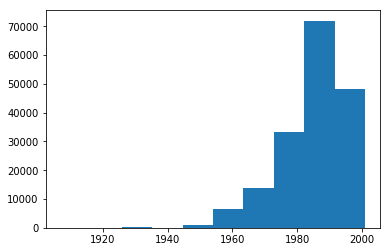

In [19]:
#Current behavior of the variable member_birth_year
print(df.member_birth_year.describe())
plt.hist(df.member_birth_year.dropna());

count    183412.000000
mean       1984.809240
std           9.863941
min        1907.000000
25%        1981.000000
50%        1987.000000
75%        1992.000000
max        2001.000000
Name: member_birth_year, dtype: float64


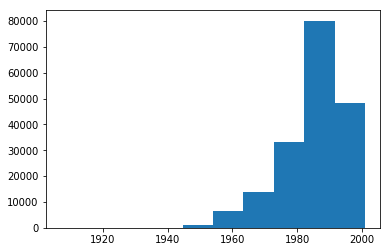

In [20]:
#Behavior of the variable member_birth_year replacing null values with the mean of the data
print(df.member_birth_year.fillna(df.member_birth_year.mean()).describe())
plt.hist(df.member_birth_year.fillna(df.member_birth_year.mean()));

In [21]:
df["member_birth_year"] = df.member_birth_year.fillna(df.member_birth_year.mean())

From the years of birth of the users, we will calculate their ages in 2019 when the data was collected

In [22]:
df["member_age"] = 2019 - df["member_birth_year"]

### Update variable types

In [23]:
df.dtypes

duration_sec                 int64
start_time                  object
end_time                    object
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
complete_start_name         object
complete_end_name           object
member_age                 float64
dtype: object

These are the settings for the variable types:

* start/end time are as object and not in datetime format
* member_birth_year does not require any precision, can be treated as int
* member_gender and bike_share_for_all_trip can be treated as categorical variables

In [24]:
#Transformation to datetime
df["start_time"] = pd.to_datetime(df["start_time"])
df["end_time"] = pd.to_datetime(df["end_time"])

#Transformation to int
df["member_birth_year"] = df["member_birth_year"].astype(int)

#Transformation to category
df["member_gender"] = df["member_gender"].astype("category")
df["bike_share_for_all_trip"] = df["bike_share_for_all_trip"].astype("category")

In [25]:
df.dtypes

duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                             int64
user_type                          object
member_birth_year                   int64
member_gender                    category
bike_share_for_all_trip          category
complete_start_name                object
complete_end_name                  object
member_age                        float64
dtype: object

### Creation of columns associated with the *start date*

In order to analyze the time variable in these data, both the time of day in which the trip was made, as well as the day of the week of the start date of the trips are extracted, with this, it is possible to analyze if there are behaviors specific by day of the week and by hour of each day.

In [26]:
#Create day of week column

df["start_time_day"] = df["start_time"].dt.day_name()#df["start_time"].dt.weekday_name

In [27]:
df.start_time_day.value_counts()

Thursday     35197
Tuesday      31813
Wednesday    29641
Friday       28981
Monday       26852
Sunday       15523
Saturday     15405
Name: start_time_day, dtype: int64

In [28]:
df["start_time_hour"] = df["start_time"].dt.hour

In [29]:
df.start_time_hour.value_counts()

17    21864
8     21056
18    16827
9     15903
16    14169
7     10614
19     9881
15     9174
12     8724
13     8551
10     8364
14     8152
11     7884
20     6482
21     4561
6      3485
22     2916
23     1646
0       925
5       896
1       548
2       381
4       235
3       174
Name: start_time_hour, dtype: int64

In [30]:
df.isna().sum()

duration_sec               0
start_time                 0
end_time                   0
start_station_name         0
start_station_latitude     0
start_station_longitude    0
end_station_name           0
end_station_latitude       0
end_station_longitude      0
bike_id                    0
user_type                  0
member_birth_year          0
member_gender              0
bike_share_for_all_trip    0
complete_start_name        0
complete_end_name          0
member_age                 0
start_time_day             0
start_time_hour            0
dtype: int64

### What is/are the main feature(s) of interest in your dataset?

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             183412 non-null  int64         
 1   start_time               183412 non-null  datetime64[ns]
 2   end_time                 183412 non-null  datetime64[ns]
 3   start_station_name       183412 non-null  object        
 4   start_station_latitude   183412 non-null  float64       
 5   start_station_longitude  183412 non-null  float64       
 6   end_station_name         183412 non-null  object        
 7   end_station_latitude     183412 non-null  float64       
 8   end_station_longitude    183412 non-null  float64       
 9   bike_id                  183412 non-null  int64         
 10  user_type                183412 non-null  object        
 11  member_birth_year        183412 non-null  int64         
 12  member_gender   

Among the resulting variables after data preparation, some that may be important to describe the characteristics of the bike-sharing program may be:

* duration_sec, start_time, end_time: To know the hours of greatest use of the service, as well as the average duration of the trips made in these
* start/end_station_name, start/end_station_latitude/longitude: To know which are the areas with the highest number of loans


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Especially the features of duration of the routes, user characteristics, the locations of the routes and the dates of use of the service, with this it is possible to have a general idea of the performance of the bike-sharing program

## Univariate Exploration

In [32]:
df.describe()

duration_sec  start_station_latitude  start_station_longitude  \
count  183412.000000           183412.000000            183412.000000   
mean      726.078435               37.771223              -122.352664   
std      1794.389780                0.099581                 0.117097   
min        61.000000               37.317298              -122.453704   
25%       325.000000               37.770083              -122.412408   
50%       514.000000               37.780760              -122.398285   
75%       796.000000               37.797280              -122.286533   
max     85444.000000               37.880222              -121.874119   

       end_station_latitude  end_station_longitude        bike_id  \
count         183412.000000          183412.000000  183412.000000   
mean              37.771427            -122.352250    4472.906375   
std                0.099490               0.116673    1664.383394   
min               37.317298            -122.453704      11.000000   
25%               37.770407            -122.411726    3777.000000   
50%               37.781010            -122.398279    4958.000000   
75%               37.797320            -122.288045    5502.000000   
max               37.880222            -121.874119    6645.000000   

       member_birth_year     member_age  start_time_hour  
count      183412.000000  183412.000000    183412.000000  
mean         1984.772774      34.190760        13.458421  
std             9.865369       9.863941         4.724978  
min          1907.000000      18.000000         0.000000  
25%          1981.000000      27.000000         9.000000  
50%          1987.000000      32.000000        14.000000  
75%          1992.000000      38.000000        17.000000  
max          2001.000000     112.000000        23.000000

**Variable duration_sec**

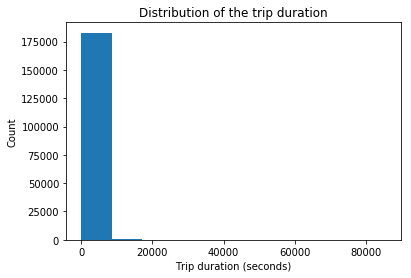

In [33]:
plt.hist(data = df, x = "duration_sec")
plt.title("Distribution of the trip duration");
plt.xlabel("Trip duration (seconds)");
plt.ylabel("Count");

Since the duration of the trips in seconds has such strong outliers as to not show such a clear distribution of the data, we will change the bins so that the existing trend is more easily noticed. Since we are working with seconds, we could define the bins from the number of seconds in a minute as follows:

In [34]:
percentiles_required = [0.75, 0.9, 0.95, 0.99]

print("Duration_sec percentiles: \n")

for percentile in percentiles_required:
    print(str(percentile*100) + "%: " + str(df.duration_sec.quantile(percentile)))

Duration_sec percentiles: 

75.0%: 796.0
90.0%: 1178.0
95.0%: 1571.0
99.0%: 3458.889999999985


We can see that by plotting only the values up to certain percentiles, the existence of a right-skewed distribution becomes more evident, where most trips do not require that much time. For example, we can say that 90% of trips are usually less than 20 minutes approximately.

In [35]:
def hist_subplots(df, column_name, figsize, n_rows, n_columns,
                  max_bin_list, bin_space, list_percentiles, scale = "normal", 
                  min_bin = 0, ticks = [], bin_measure = "", title = "", xlabel = "", ylabel = ""):

    plt.figure(figsize = figsize)
    for i in range(1,(n_rows*n_columns)+1): 
    
        plt.subplot(n_rows,n_columns,i)
        
        if scale == "log":
            
            bin_edges = np.e ** np.arange(min_bin, max_bin_list[i-1], bin_space[i-1])
            
            labels = ['{}'.format(v) for v in ticks]
            
            plt.hist(df[column_name], bins = bin_edges);
            plt.title("{} \n(up to percentil {} | bin size: {} {})".format(title, list_percentiles[i-1], bin_space[i-1], bin_measure))
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.xscale("log")
            plt.xticks(ticks, labels);
            
        else:
            
            bin_edges = np.arange(min_bin,max_bin_list[i-1],bin_space[i-1])
            
            plt.hist(df[column_name], bins = bin_edges);
            plt.title("{} \n(up to percentil {} | bin size: {} {})".format(title, list_percentiles[i-1], bin_space[i-1], bin_measure))
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

    #https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
    plt.tight_layout()

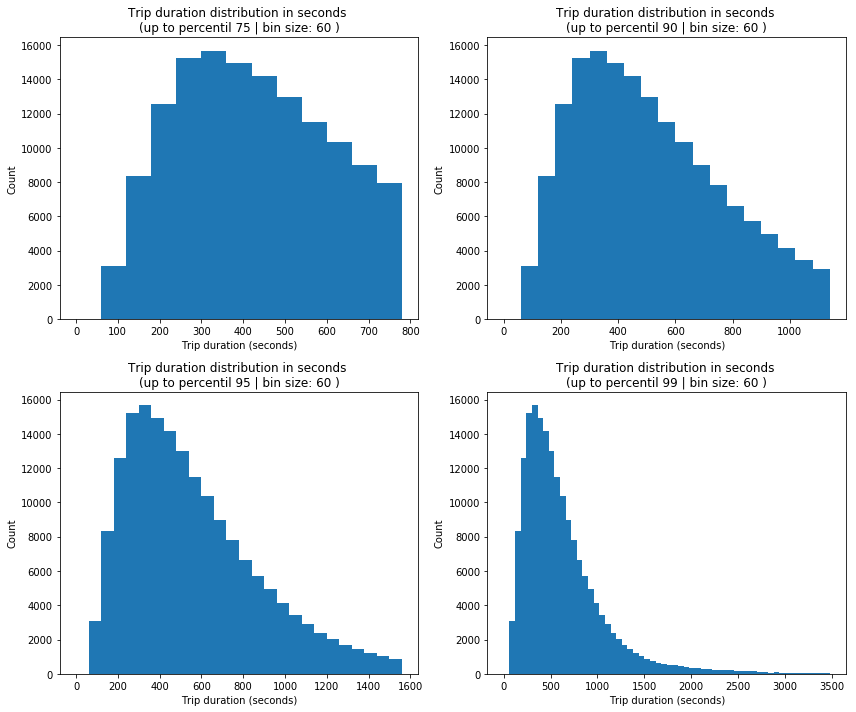

In [36]:
#### Histograms of the trip duration variable up to the nth percentile

column_name = "duration_sec"
figsize = (12,10)
n_rows = 2
n_columns = 2
title = "Trip duration distribution in seconds"
xlabel = "Trip duration (seconds)"
ylabel = "Count"
max_bin_list = [800, 1200, 1600, 3500]
bin_space = [60]*4
list_percentiles = ["75", "90", "95", "99"]

hist_subplots(df, column_name, figsize, n_rows, n_columns, 
              max_bin_list, bin_space, list_percentiles, 
              title = title, xlabel = xlabel, ylabel = ylabel)

Given this distribution of the data, we can also review their behavior but through a logarithmic transformation to show if it has any log-normal behavior.

In [37]:
percentiles_required = [0.75, 0.9, 0.95, 0.99, 1]

print("Duration_sec percentiles in log scale: \n")

for percentile in percentiles_required:
    print(str(percentile*100) + "%: " + str(np.log(df.duration_sec).quantile(percentile)))

Duration_sec percentiles in log scale: 

75.0%: 6.679599185844383
90.0%: 7.071573364211532
95.0%: 7.359467638255621
99.0%: 8.148703003240831
100%: 11.355616469577566


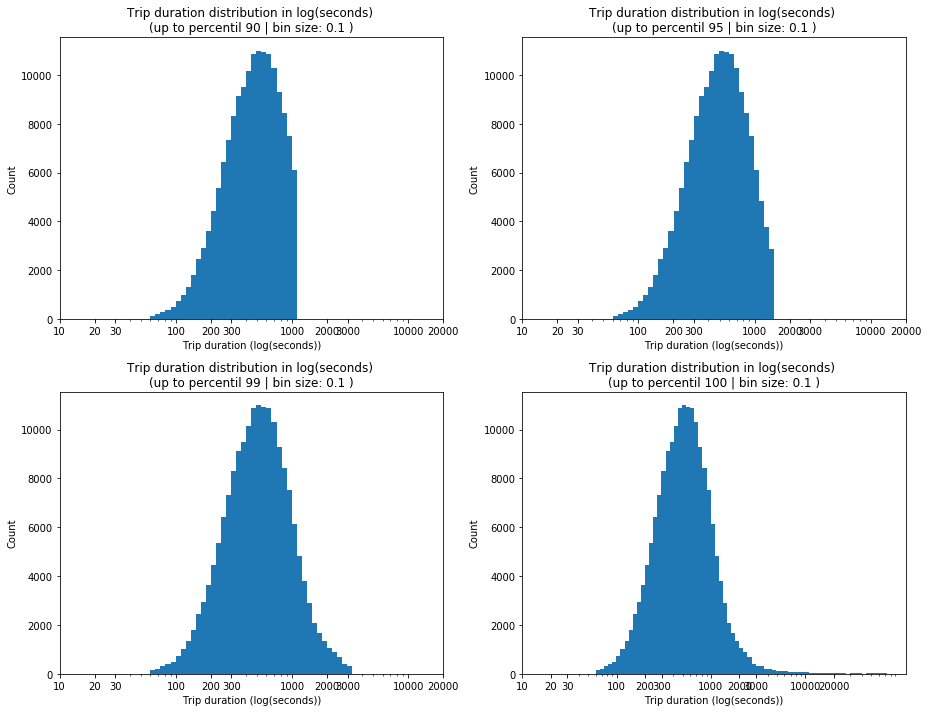

In [38]:
#### Histograms of the trip duration variable up to the nth percentile

column_name = "duration_sec"
scale = "log"
figsize = (13,10)
n_rows = 2
n_columns = 2
title = "Trip duration distribution in log(seconds)"
xlabel = "Trip duration (log(seconds))"
ylabel = "Count"
min_bin = 4
max_bin_list = [7.1, 7.4, 8.2, 11.36]
bin_space = [0.1]*4
list_percentiles = ["90", "95", "99", "100"]
ticks = [10, 20, 30, 100, 200, 300, 1000, 2000, 3000, 10000, 20000] 

hist_subplots(df, column_name, figsize, n_rows, n_columns, max_bin_list, 
              bin_space, list_percentiles, scale, min_bin, ticks,
              title = title, xlabel = xlabel, ylabel = ylabel)

**Variable member_birth_year**

In [39]:
df.member_birth_year.quantile(0.1)

1971.0

We can see that in general we have a distribution skewed to the left, where we can see that few elderly people use this service (approximately 90% of people are under 48 years old)

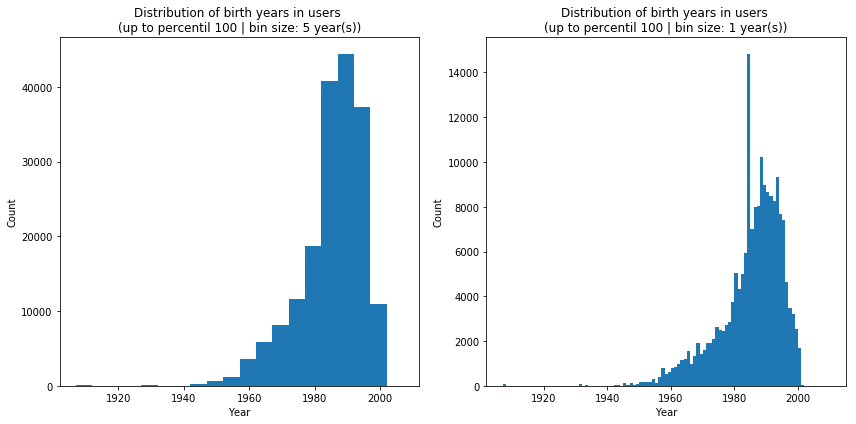

In [40]:
#### Histograms of the variable birth year up to percentile n

column_name = "member_birth_year"
figsize = (12,6)
n_rows = 1
n_columns = 2
title = "Distribution of birth years in users"
xlabel = "Year"
ylabel = "Count"
min_bin = df.member_birth_year.min()
max_bin_list = [df.member_birth_year.max()+10]*2
bin_space = [5,1]
bin_measure = "year(s)"
list_percentiles = ["100"] * 2
scales = "normal"


hist_subplots(df, column_name, figsize, n_rows, n_columns, 
              max_bin_list, bin_space, list_percentiles,
              min_bin = min_bin, bin_measure = bin_measure, title = title, xlabel = xlabel, ylabel = ylabel)

However, for a better understanding, it is worth using the age calculated in 2019 according to the year of birth. In this way it is easier to visualize the proportion of ages. Additionally, due to the right-skewed behavior of the data, it is worth applying a transformation to it as well to see if there is any pattern.

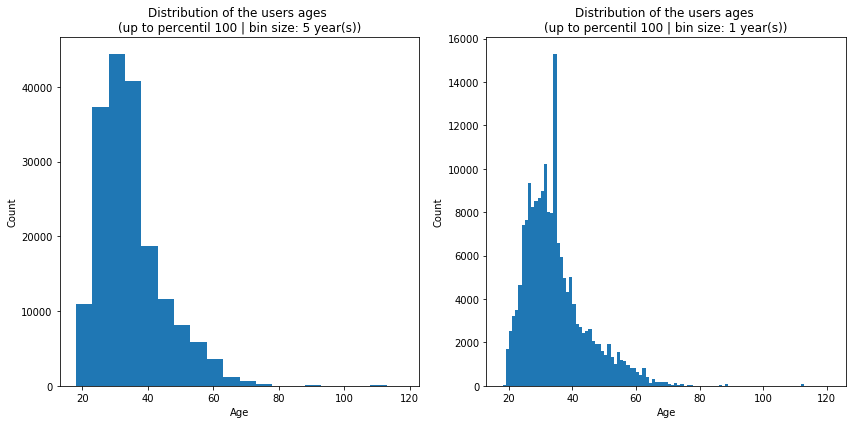

In [41]:
#### Histograms of the age variable up to the nth percentile
column_name = "member_age"
figsize = (12,6)
n_rows = 1
n_columns = 2
title = "Distribution of the users ages"
xlabel = "Age"
ylabel = "Count"
min_bin = df.member_age.min()
max_bin_list = [df.member_age.max()+10]*2
bin_space = [5,1]
bin_measure = "year(s)"
list_percentiles = ["100"] * 2
scales = "normal"


hist_subplots(df, column_name, figsize, n_rows, n_columns, 
              max_bin_list, bin_space, list_percentiles,
              min_bin = min_bin, bin_measure = bin_measure, title = title, xlabel = xlabel, ylabel = ylabel)

**Variable user_type**

In this case, we can see that the number of trips made by customers who are subscribers of the program (customers who buy a monthly or annual subscription), is much higher than the number of trips made by regular customers (customers who take individual trips without subscription)

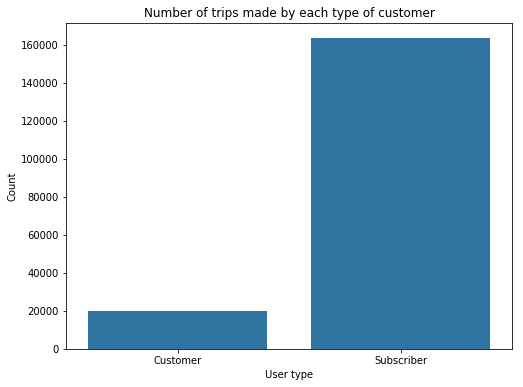

In [42]:
color_base = sb.color_palette()[0]

plt.figure(figsize = (8,6))
sb.countplot(data = df, x = "user_type", color = color_base);
plt.title("Number of trips made by each type of customer");
plt.xlabel("User type");
plt.ylabel("Count");

**Variable member_gender**

In general, it seems that men are the ones who benefit the most from this service, since most of the trips made were by male clients.

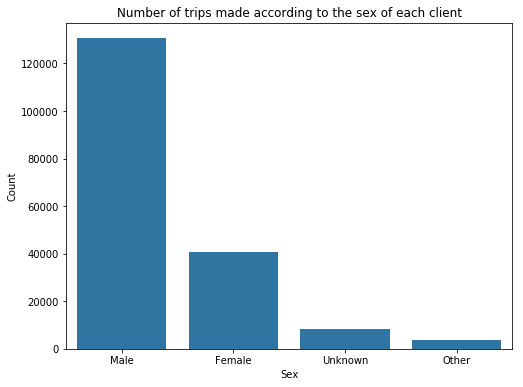

In [43]:
color_base = sb.color_palette()[0]

plt.figure(figsize = (8,6))
category_order = df['member_gender'].value_counts().index
sb.countplot(data = df, x = "member_gender", order = category_order, color = color_base);
plt.title("Number of trips made according to the sex of each client")
plt.xlabel("Sex");
plt.ylabel("Count");

**Variable bike_share_for_all_trip**

This variable represents whether the customer is part of the "Bike share for all" program or not, this program provided access to the service to low-income people [Source](https://mtc.ca.gov/news/ford-gobike-fast-track-equity-inclusion-bike-share-all-hits-500-member-mark). The number of trips made by this modality is minimum compared to the rest of the trips made by other clients, about 10%.

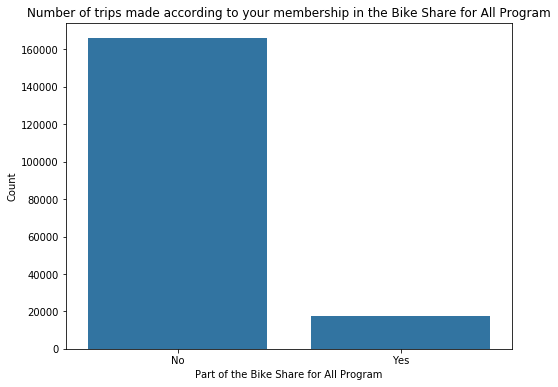

In [44]:
color_base = sb.color_palette()[0]

plt.figure(figsize = (8,6))
category_order = df['bike_share_for_all_trip'].value_counts().index
sb.countplot(data = df, x = "bike_share_for_all_trip", order = category_order, color = color_base);
plt.title("Number of trips made according to your membership in the Bike Share for All Program")
plt.xlabel("Part of the Bike Share for All Program");
plt.ylabel("Count");

**Variable start_time_day**

This variable represents the number of total trips that have been made each day of the week. In this case we can notice that there is a certain concentration of trips on business days of the week, especially Tuesday and Thursday.

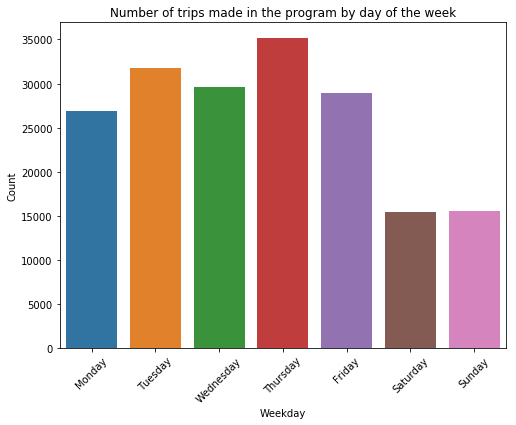

In [45]:
color_base = sb.color_palette()[0]

plt.figure(figsize = (8,6))
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sb.countplot(data = df, x = "start_time_day", order = day_order);
plt.title("Number of trips made in the program by day of the week")
plt.xlabel("Weekday")
plt.ylabel("Count")
plt.xticks(rotation = 45);

**Variable start_station_name**

Here we can see that the concentration of trips in some of the stations is too high without comparing the stations with the highest number of trips and those with the least number of trips (highest: 3904 vs. lowest: 1-2)

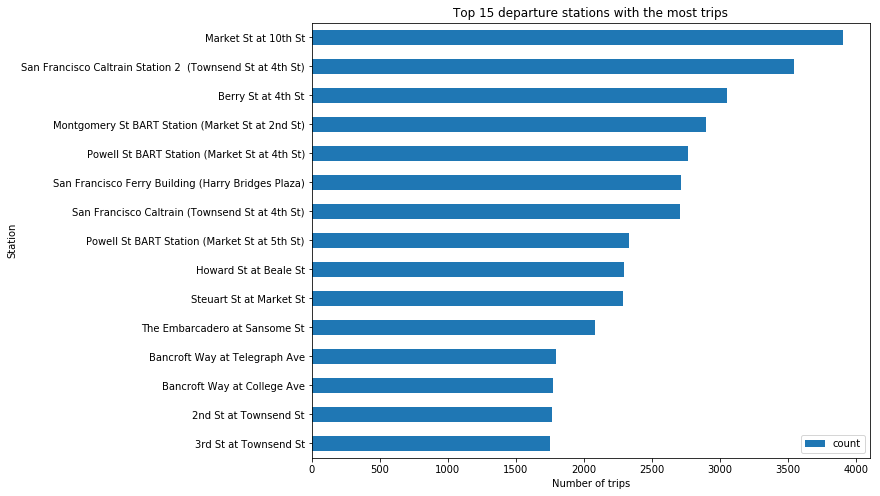

In [46]:
df_plot = pd.DataFrame(df['start_station_name'].value_counts()).reset_index().nlargest(15, "start_station_name")
df_plot.columns = ["start_station_name", "count"]
df_plot = df_plot.sort_values('count')

palette_color = sb.color_palette()[0]
plt.figure(figsize = (10,8))

df_plot.set_index("start_station_name").plot(kind = "barh", figsize = (10,8));
plt.title("Top 15 departure stations with the most trips");
plt.xlabel("Number of trips");
plt.ylabel("Station");

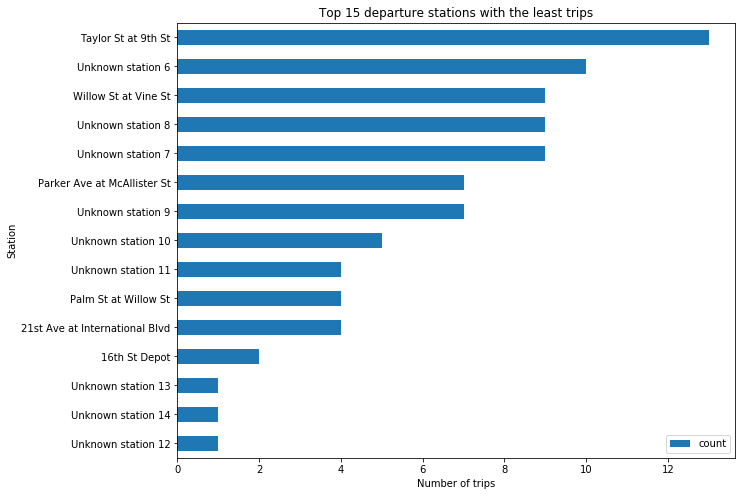

In [47]:
df_plot = pd.DataFrame(df['start_station_name'].value_counts()).reset_index().nsmallest(15, "start_station_name")
df_plot.columns = ["start_station_name", "count"]
df_plot = df_plot.sort_values('count')

palette_color = sb.color_palette()[0]
plt.figure(figsize = (10,8))

df_plot.set_index("start_station_name").plot(kind = "barh", figsize = (10,8));
plt.title("Top 15 departure stations with the least trips");
plt.xlabel("Number of trips");
plt.ylabel("Station");

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The duration_sec variable has many outliers and the possibility of being transformed through the application of the logarithm to its data. Likewise, the distribution of the years of the users of the program suggests that few older people make use of this service, being mainly for people aged around 20-50 years.

> The difference between the number of trips made by customers of each sex must be taken into account, since the trips made by men are just over double those made by women.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> The trend between the number of trips per day of the week gives a certain indication of a possible special behavior throughout the week that is worth deepening using other graphs.

> There are several stations in which a large number of trips are concentrated and others in which not many are made, it is necessary to delve into the possible segmentation that causes more or fewer trips to be made in certain stations

## Bivariate Exploration

**Variables duration_sec and member_age**

Through this graph, we see the relationship between the age of each client and the duration of the trips (in seconds) of the trip he made. In general, we can see that the longest trips are mainly made by people between 20 and 40 years old, while older people do not usually take too long trips.

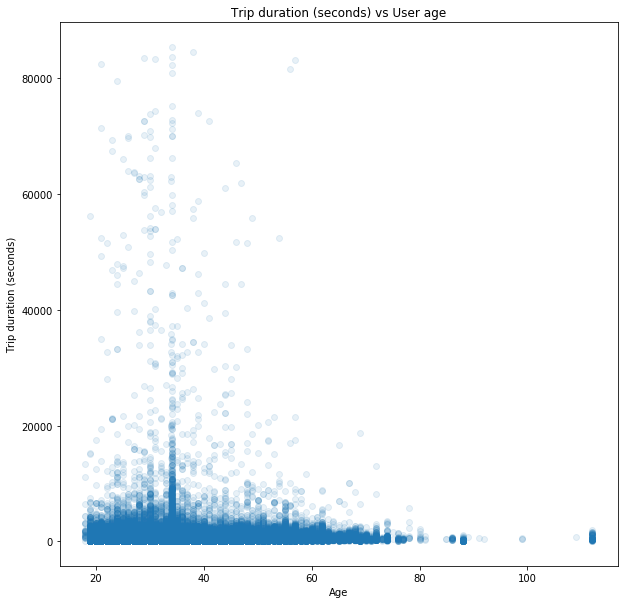

In [48]:
plt.figure(figsize = (10,10))
plt.scatter(data = df, x = "member_age", y = "duration_sec", alpha = 0.1)
plt.title("Trip duration (seconds) vs User age");
plt.xlabel("Age");
plt.ylabel("Trip duration (seconds)");

**Variables duration_sec and member_gender**

Continuing with the trip duration variable, we are now going to review it based on the sex of the person who made the trip. In this case, we initially find that there are many outliers, so we reduce the scale we wish to present to further define gender differences. In general, women take longer trips than the other sexes

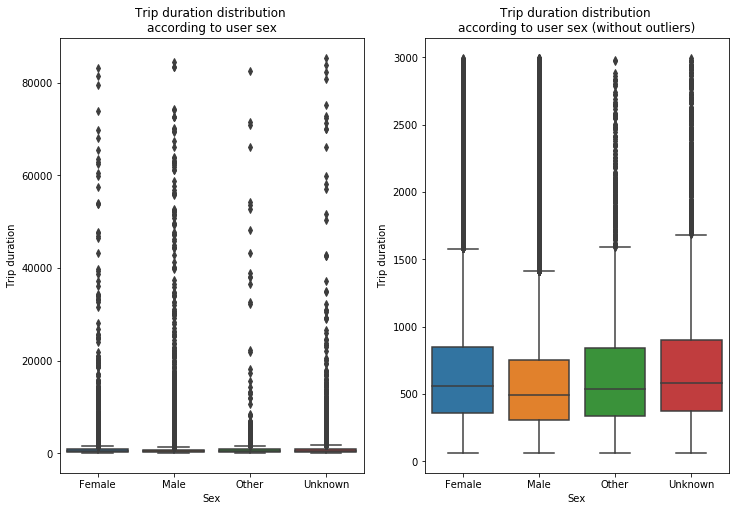

In [49]:
plt.figure(figsize = (12,8))

plt.subplot(1,2,1)
sb.boxplot(data = df, x = "member_gender", y = "duration_sec")
plt.title("Trip duration distribution \naccording to user sex")
plt.xlabel("Sex");
plt.ylabel("Trip duration");

plt.subplot(1,2,2)
sb.boxplot(data = df[df.duration_sec < 3000], x = "member_gender", y = "duration_sec")
plt.title("Trip duration distribution \naccording to user sex (without outliers)")
plt.xlabel("Sex");
plt.ylabel("Trip duration");

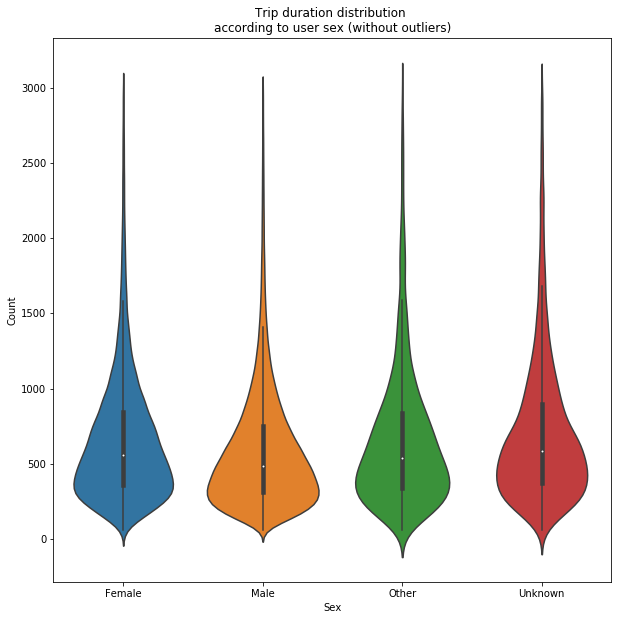

In [50]:
plt.figure(figsize = (10,10))
sb.violinplot(data = df[df.duration_sec < 3000], x = "member_gender", y = "duration_sec")
plt.title("Trip duration distribution \naccording to user sex (without outliers)")
plt.xlabel("Sex");
plt.ylabel("Count");

**Variables start_time_day and duration_sec**

Now we will see if there are significant differences in the duration of the trips according to the day of the week in which they are made. Similar to client gender, certain outliers must be removed to make the data distribution more visible. In this case, we can a variation in the duration of the trips that are made on weekends against the trips during the week. Weekend trips are usually longer

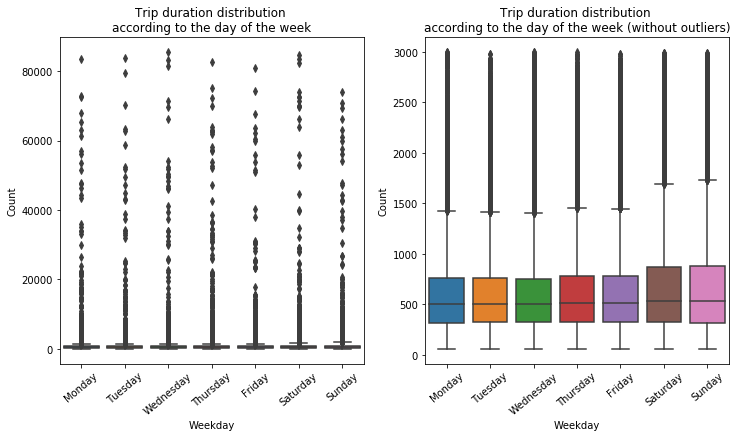

In [51]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sb.boxplot(data = df, x = "start_time_day", y = "duration_sec", order = day_order)
plt.title("Trip duration distribution \naccording to the day of the week")
plt.xlabel("Weekday");
plt.ylabel("Count");
plt.xticks(rotation = 40);

plt.subplot(1,2,2)
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sb.boxplot(data = df[df.duration_sec < 3000], x = "start_time_day", y = "duration_sec", order = day_order)
plt.title("Trip duration distribution \naccording to the day of the week (without outliers)")
plt.xlabel("Weekday");
plt.ylabel("Count");
plt.xticks(rotation = 40);

**Variables start_time and number of trips per day**

Here we can see the number of trips that were made daily throughout the month of February 2019. We see that there is a certain weekly seasonality, since on Saturday and Sunday of each week the number of bicycle trips decreases considerably, while between week are much higher.

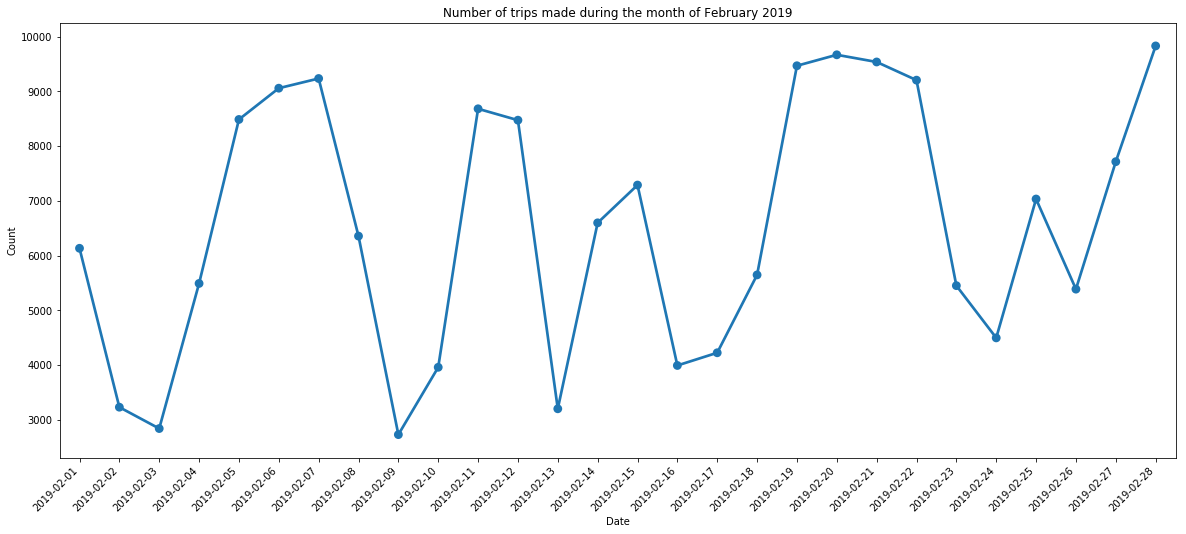

In [52]:
#Number of trips made each day

df_plot = df.groupby(pd.Grouper(key='start_time', axis=0, 
                      freq='D')).count().iloc[:,1].reset_index()
df_plot["start_time"] = df_plot["start_time"].apply(lambda x: x.date())

#https://stackoverflow.com/questions/51105648/ordering-and-formatting-dates-on-x-axis-in-seaborn-bar-plot

fig, ax = plt.subplots(figsize = (20,8))
fig = sb.pointplot(data = df_plot, x = "start_time", y = "end_time", ax = ax)
ax.set_xticklabels(labels=df_plot.start_time, rotation=45, ha='right');
plt.title("Number of trips made during the month of February 2019")
plt.xlabel("Date");
plt.ylabel("Count");

**Variables start_time(hour) and number of trips per day**

In terms of number of trips but for each hour of the day, we see that there are peaks in the use of the service in what would be considered "rush hours" (8 and 17). Since we can relate these hours of the day with the hours in which people generally go to work and leave work.

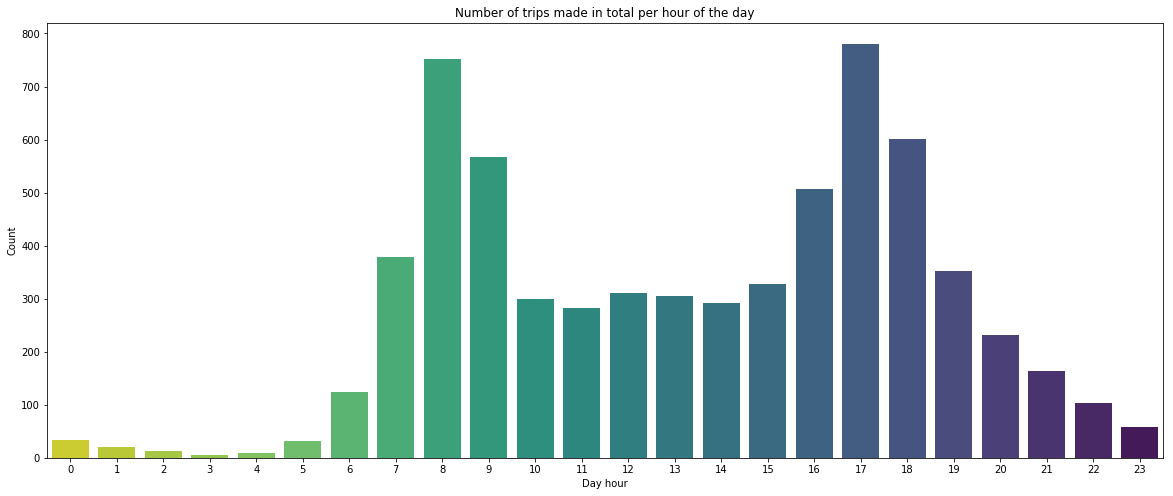

In [53]:
#Graph of the average trips made on average every hour of the day

prueba = df.groupby(pd.Grouper(key='start_time', axis=0, 
                      freq='H')).count().iloc[:,1].reset_index()
prueba["hour"] = prueba.start_time.dt.hour
prueba = prueba.groupby("hour").mean().reset_index()
plt.figure(figsize = (20,8))
sb.barplot(data = prueba, x = "hour", y = "end_time", palette = "viridis_r")
plt.title("Number of trips made in total per hour of the day");
plt.xlabel("Day hour");
plt.ylabel("Count");

**Variables member_age and member_gender**

In general, people belonging to the "Other" sex have a higher median age with men, as well as men with women. In general terms, those who tend to be older are men.

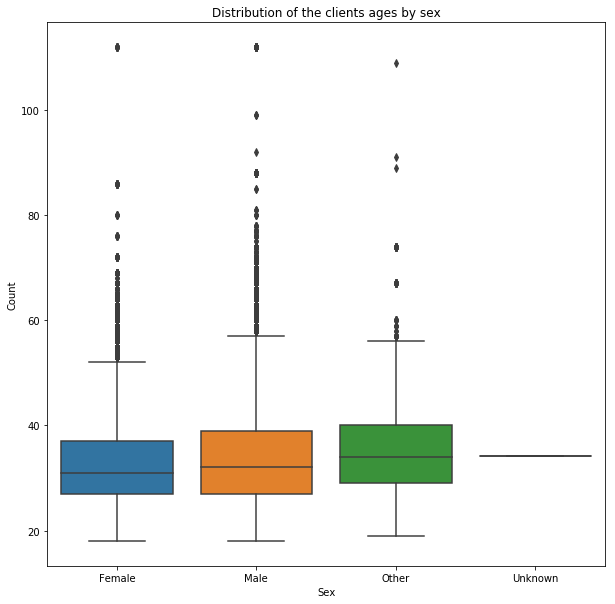

In [54]:
plt.figure(figsize = (10,10))
sb.boxplot(data = df, x = "member_gender", y = "member_age")
plt.title("Distribution of the clients ages by sex");
plt.xlabel("Sex");
plt.ylabel("Count");

**Variable member_gender and user_type**

In this case we can see how the number of subscribers varies by gender, and in general, there is a greater number in men. The number of regular customers is very low compared to subscribers.

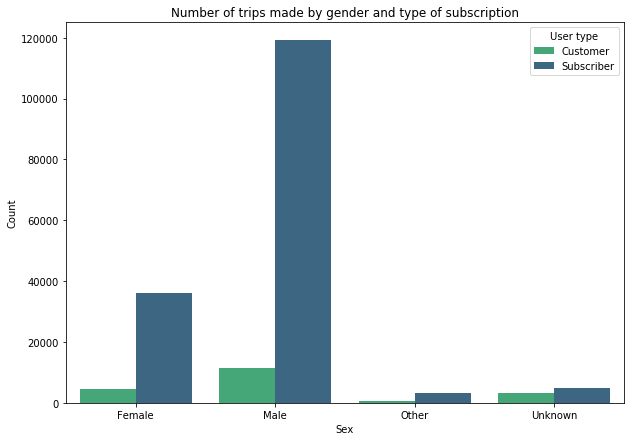

In [55]:
plt.figure(figsize = (10,7))
sb.countplot(data = df, x = 'member_gender', hue = 'user_type',
          palette = "viridis_r")
plt.title("Number of trips made by gender and type of subscription");
plt.xlabel("Sex");
plt.ylabel("Count");
plt.legend(title = "User type");

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> There is certain relationship between the duration of the trips and the age of the user, since in general, older people have shorter trips, while the longest trips are concentrated in people between 20 and 50 years old

>The distribution of the duration of the trips by day of the week allows us to show that longer trips are made on weekends than during the week.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> When reviewing how many trips were made each day during the month of February, we see evidence of the possible existence of a weekly seasonality since the number of trips made always decreases too much on weekends

>In terms of hours of the day, we see a big difference between the number of trips that are made per hour of the day. Usage peaks stand out at 8 a.m. and 5 p.m. (which coincide with office entry and exit times)

## Multivariate Exploration

In this case, we see a considerable difference between the duration of the trips made by people of the "Other" sex. While in the case of men and women, these are usually quite similar.

**Variables duration_sec, member_age and member_gender**

Text(29.0378,0.5,'Trip duration (sec)')

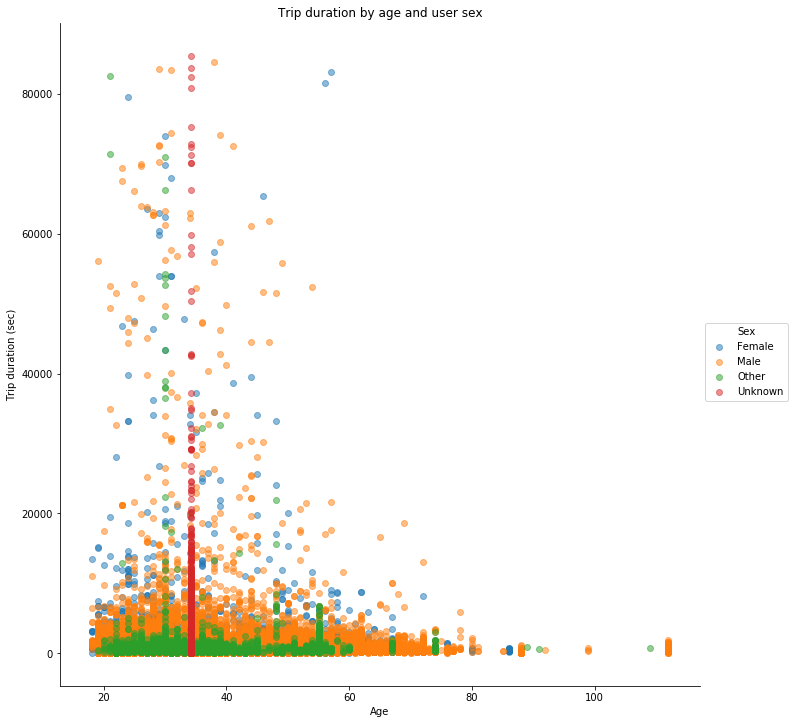

In [56]:
g = sb.FacetGrid(data = df, hue = 'member_gender', size = 10,
                 palette = sb.color_palette(n_colors=4))
g.map(plt.scatter, 'member_age', 'duration_sec', alpha = 0.5)
g.add_legend(title = "Sex")
plt.title("Trip duration by age and user sex")
plt.xlabel("Age")
plt.ylabel("Trip duration (sec)")

**Variables member_gender, duration_sec and user_type**

Here we can see that on average, the trips made by women (both Customer and Subscriber) are longer than those made by men. However, those who make longer trips on average are people with "Other" sex, but this is also due to the fact that they have a greater dispersion in their values. In addition, "Customer" type users always have, on average, longer trips than "Subscriber" type users, regardless of gender.

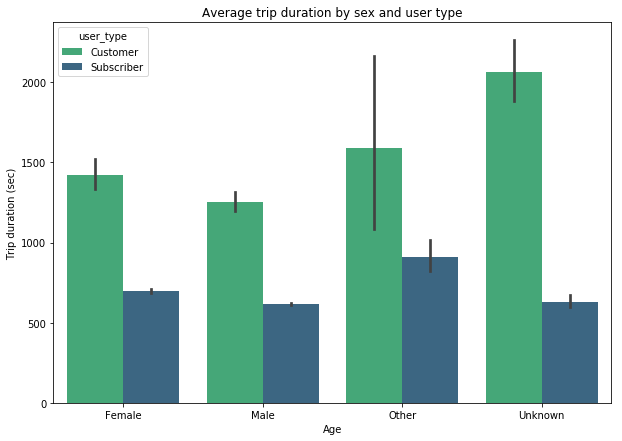

In [57]:
plt.figure(figsize = (10,7))
sb.barplot(data = df, x = 'member_gender', y = "duration_sec", hue = 'user_type',
          palette = "viridis_r")
plt.title("Average trip duration by sex and user type");
plt.xlabel("Age");
plt.ylabel("Trip duration (sec)");
#plt.ylim((7.5,9))

**Variables member_gender, member_age and user_type**

Similarly, in terms of age, people of the "Other" sex are on average older than men, and men older than women. In general, "Subscriber" type users are older on average than "Customer" type users, regardless of gender.

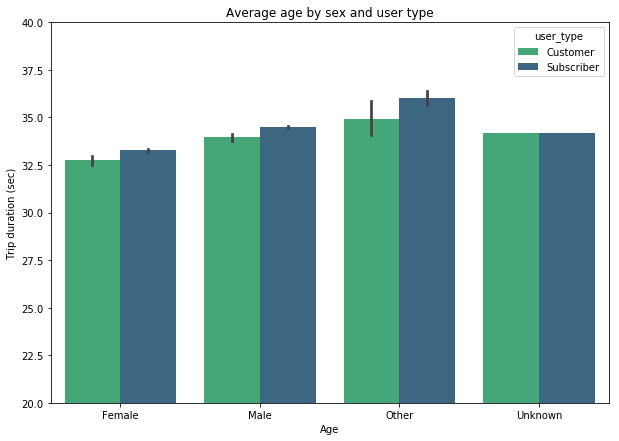

In [58]:
plt.figure(figsize = (10,7))
sb.barplot(data = df, x = 'member_gender', y = "member_age", hue = 'user_type',
          palette = "viridis_r")
plt.title("Average age by sex and user type");
plt.xlabel("Age");
plt.ylabel("Trip duration (sec)");
plt.ylim((20,40));

**Variables start_time(hour), number of trips per day and member_gender**

In this case, we see that the number of trips made at each hour of the day by gender have the same behavior in which there are peaks during some hours of the day that we can associate with the classic office hours (8-17)

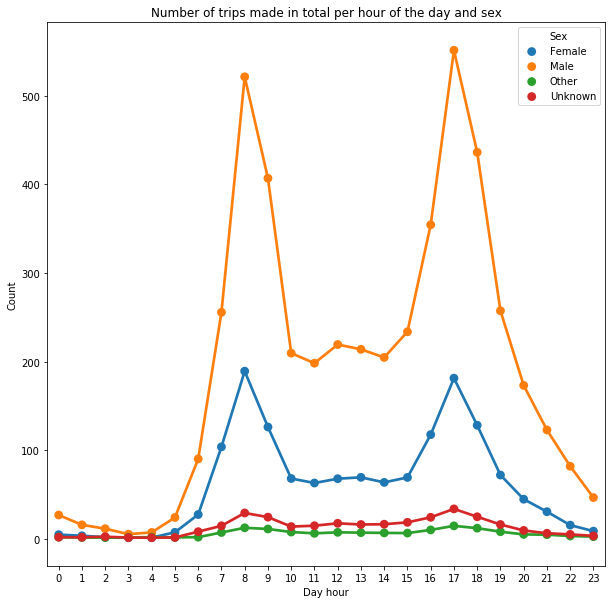

In [59]:
#Gráfico de la media de viajes que se realizan cada hora del día

df_plot = df.groupby([pd.Grouper(key='start_time', axis=0, 
                      freq='H'), "member_gender"]).count().iloc[:,1].reset_index()
df_plot["hour"] = df_plot.start_time.dt.hour
df_plot = df_plot.groupby(["hour","member_gender"]).mean().reset_index()

plt.figure(figsize = (10,10))
sb.pointplot(data = df_plot, x = "hour", y = "end_time", hue = "member_gender")
plt.title("Number of trips made in total per hour of the day and sex");
plt.xlabel("Day hour");
plt.ylabel("Count");
plt.legend(title = "Sex")

The following code was retrieved from the Github repository [Source](https://github.com/fravellaneda/airbnb), which is about a study of the importance of location on Airbnb prices in Seattle. With it, we will seek to get an idea of how the number of trips made in the different stations that the system has is distributed.

In [60]:
df_map_plot = df.groupby(["start_station_name", "start_station_latitude", "start_station_longitude"]).count().duration_sec.reset_index()

In [61]:
before=0 # code for add percentiles to the data
df_map_plot['color_number'] = 0 #column for adding the color 

for i in range(1,101): # I use 100 percentiles
    percentile=np.percentile(df_map_plot['duration_sec'], i) # calculate the percentile
    df_map_plot.loc[(df_map_plot['duration_sec']<=percentile) &
                    (df_map_plot['duration_sec']>before),'percentile'] = '['+str((i-1))+'-'+str(i)+')' #save column
    df_map_plot.loc[(df_map_plot['duration_sec']<=percentile) &
                    (df_map_plot['duration_sec']>before),'color_number'] = i-1 # save number
    before=percentile # save the before percentile

In [62]:
red = Color("red") # red color
colors = list(red.range_to(Color("green"),102)) # creates 100 colors between red and green
colors_list=[] # save the colors in a list
for i in range(1,101):
    colors_list.append(str(list(colors)[i]))

In [63]:
def create_map(df):
    
    m = folium.Map(location=[df['start_station_latitude'].mean(), df['start_station_longitude'].mean()], 
                   zoom_start=9, tiles='Stamen Toner')
    
    for _, row in df.iterrows():
            
        folium.Circle(
            location= [row['start_station_latitude'], row['start_station_longitude']],
            radius=100,
            color=colors_list[row['color_number']],
            popup='Percentile: '+str(row['percentile']),
            fill=False,
            fill_color=colors_list[row['color_number']]
        ).add_to(m)
        
    return m

Three areas of operation of the bike-sharing program are identified: San Francisco, Berkeley and San Jose. In general, San Francisco stations make the most trips, with Berkeley in second place and San Jose in third place. In the case of San Jose, perhaps it is because it is an area far from the core of San Francisco.

In [64]:
m = create_map(df_map_plot)
m

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> In addition to there being a relationship between age and the duration of the trips, the sex of the user also seems to have a slight influence. Since there are certain differences between them.

> On average, women have longer trips than men. However, people of "Other" sex present higher values but with greater variability. Additionally, "Customer" type users always tend to have a longer average trip duration, regardless of gender.

### Were there any interesting or surprising interactions between features?

> The difference in the number of trips made between the 3 zones of the program: San Francisco, Berkeley and San Jose. Since in each of them there is a greater or lesser number of trips made from each station.

## Conclusions
>With the data provided we have a series of interesting insights about the operation of the program. 

>In the first place, we can review the duration of the tours, where the distribution of these durations presents a log-normal behavior. These durations present a relationship with the age of the user, the older, the shorter the duration of the trips, and vice versa; in addition to having a certain relationship with the sex of the people and with the days of the week, where we see that weekends have longer durations than trips during the week. 

>On the other hand, associated with the characteristics of the times in which the trips are made, there is a certain weekly seasonality in the number of trips that are made per day, since in general, on weekends there are fewer trips than on weekends. weekday. 

>In addition, there is a quite interesting relationship between the number of trips made and the time of day, where the largest number of trips coincides precisely with what is usually the "rush hour" in the offices (arrival and departure times | 8 and 17)

>Finally, we have a very interesting component in how the location affects the number of trips made from each station, finding that we can separate the stations into 3 zones, each with more or less total number of trips in their stations.